南大os主页： http://jyywiki.cn/OS/2023/

jupyter: https://jyywiki.cn/OS/2023/build/lect1.ipynb.html


为什么要学 “任何东西”？

重走从无到有的发现历程

基本思想、基本方法、里程碑、走过的弯路

最终目的：应用/创新 (做题得分不是目的而是手段)

如果只是记得几个结论，那 ChatGPT 已经做得很好了


- 7段 数码管程序来理解计算机硬件 (电路)
    
    数字逻辑电路是一个极简的公理系统 (导线、时钟、逻辑门、触发器)
    
    建立在公理体系上的数字系统设计 (包括计算机)

- 鸡兔同笼问题， 理解 软件，高级语言到 指令序列

    高级语言代码 → 指令序列 → 二进制文件 → 处理器执行
    
（要能看到事物的本质，一句话说清事物的本质）

#### 7段数码管，理解硬件

In [ ]:

#include <stdio.h>
#include <stdbool.h>
#include <unistd.h>

typedef bool wire; // Wires
typedef struct {
  bool value;
  wire *in, *out;
} reg; // Flip-flops

// Circuit constructs
#define CLOCK       for (; ; )
#define NAND(X, Y)  (!((X) && (Y)))
#define NOT(X)      (NAND(X, 1))
#define AND(X, Y)   (NOT(NAND(X, Y)))
#define OR(X, Y)    (NAND(NOT(X), NOT(Y)))

// Circuit emulation helpers
#define PRINT(X) printf(#X " = %d; ", X)

// Wire and register specification
wire X, Y, X1, Y1, A, B, C, D, E, F, G;
reg b1 = {.in = &X1, .out = &X};
reg b0 = {.in = &Y1, .out = &Y};

// Dump wire values at the end of each cycle
void end_cycle() {
  PRINT(A); PRINT(B); PRINT(C); PRINT(D);
  PRINT(E); PRINT(F); PRINT(G);
  putchar('\n');
  fflush(stdout);
}

int main() {
  CLOCK {
    // 1. Wire network specification (logic gates)
    X1 = AND(NOT(X), Y);
    Y1 = NOT(OR(X, Y));
    A = D = E = NOT(Y);
    B = 1;
    C = NOT(X);
    F = Y1;
    G = X;

    // 2. Lock data in flip-flops and propagate output to wires
    b0.value = *b0.in;
    b1.value = *b1.in;
    *b0.out = b0.value;
    *b1.out = b1.value;

    // 3. End-cycle hook
    end_cycle();
    sleep(1);
  }

}


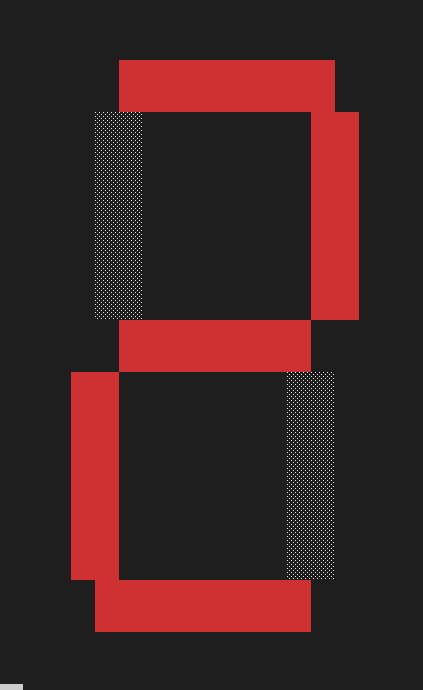



#### 鸡兔问题，理解软件的执行

In [ ]:
#include <stdio.h>
#include <stdbool.h>
#include <unistd.h>
#include <stdint.h>
#include <assert.h>

typedef uint32_t u32;

typedef struct { u32 op:7, rd:5, f3:3, rs1:5, rs2:5, f7:7; } inst_t;
typedef struct {
  u32 on, x[32];
} CPUState;

// Uncore:
//   inst_fetch - read an instruction from stdin
//   ebreak - hyper call: putchar/putd/exit
#include "uncore.c"

static inline u32 sext(u32 val, u32 n) {
  // Sign extend n-bit integer val to 32-bit
  u32 mask = ~((1 << n) - 1);
  u32 set = (val >> (n - 1)) & 1;
  u32 ret = set ? (val | mask) : val;
  return ret;
}

int main(int argc, char *argv[]) {
  CPUState cpu = {.on = 1, .x = { 0 }}; // The RESET state
  for (int i = 0; argv[i + 1] && i < 8; i++) {
    cpu.x[10 + i] = atoi(argv[i + 1]); // Set a0-a7 to arguments
  }

  inst_t in;
  while (cpu.on && inst_fetch(&in)) {
    // For each fetched instruction, execute it following the RV32I spec
    u32 op = in.op, f3 = in.f3, f7 = in.f7;
    u32 imm = sext((f7 << 5) | in.rs2, 12), shamt = in.rs2;
    u32 rd = in.rd, rs1_u = cpu.x[in.rs1], rs2_u = cpu.x[in.rs2], res = 0;

    #define __ else if // Bad syntactic sugar!  
    # 6条指令序列
    if (op == 0b0110011 && f3 == 0b000 && f7 == 0b0000000) res = rs1_u + rs2_u;
    __ (op == 0b0110011 && f3 == 0b000 && f7 == 0b0100000) res = rs1_u - rs2_u;
    __ (op == 0b0010011 && f3 == 0b000)                    res = rs1_u + imm;
    __ (op == 0b0010011 && f3 == 0b001 && f7 == 0b0000000) res = rs1_u << shamt;
    __ (op == 0b0010011 && f3 == 0b101 && f7 == 0b0000000) res = rs1_u >> shamt;
    __ (op == 0b1110011 && f3 == 0b000 && rd == 0 && imm == 1) ebreak(&cpu);
    else assert(0);
    if (rd) cpu.x[rd] = res;
  }
}

/*
# make run 
2 Head, 4 Feet:
2 0
2 Head, 6 Feet:
1 1
2 Head, 8 Feet:
0 2
35 Head, 94 Feet:
23 12
(pt2)
*/